## Applying BERT Modeling to Classify ServiceNow Tickets and Deploying using SageMaker

In [28]:
!pip install numpy torch accelerate

!pip install sagemaker
!pip install sagemaker-huggingface-inference-toolkit 
!pip install transformers==4.28.1 
!pip install datasets[s3]==2.12.0
!pip install -qq ipywidgets
!pip install -qq watermark 
!pip install -qq seaborn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can eithe

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the env

In [3]:
random_state = 138 # Set a seed for reproducibility

### Exploratory Data Analysis

In [4]:
from datasets import load_dataset, Dataset

In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('incident_fix.csv', encoding = 'cp1252')

In [7]:
data = df[['short_description','cmdb_ci']]
data = data.groupby('cmdb_ci').filter(lambda x: (x['short_description'].count()>400).any())


<BarContainer object of 22 artists>

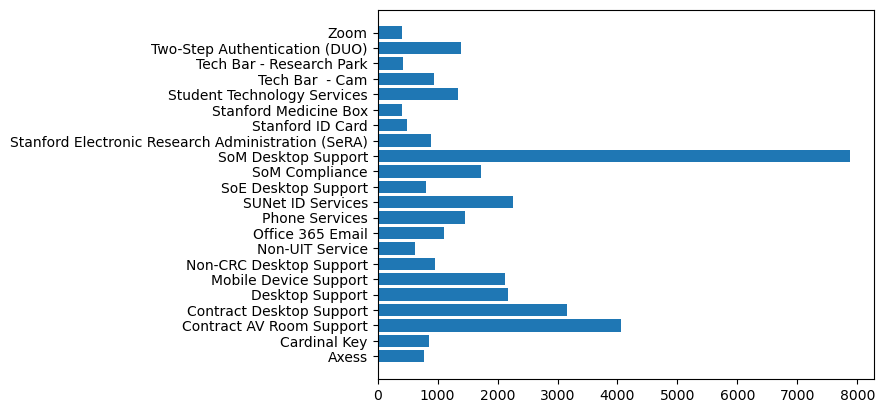

In [8]:
plot = data.groupby('cmdb_ci').count()
plt.barh(plot.index, plot['short_description'].values)

### Cleaning and pre-processing text data

In [9]:
data = data[pd.notnull(data.cmdb_ci)]
data = data[pd.notnull(data.short_description)]

In [10]:
len(data)

36270

In [11]:
# Remove extra spaces
import re
data["short_description"] = data["short_description"].apply(lambda text: re.sub(' +', ' ', text))

In [12]:
data['short_description'].values

array(['Not able to login to lane library',
       "Trouble getting into W2 on Axess - pdf tab doesn't launch",
       'SHC after hours', ...,
       '[de-stanfordize] POD MBA sn: C02DR23YQ6L7 - left Stanford; still getting Stanford alerts on my computer / CCSR',
       'IT Device Enrollment',
       "Can't fil out google form to apply for TA positions"],
      dtype=object)

### Tokenize dataset and pull pretrained model from Transformers, and initialize Trainer/TrainingArguments

In [13]:
import sagemaker
from sagemaker.huggingface import HuggingFace
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

In [14]:
# Initialize training/tokenizer parameters
model_name = "bert-base-uncased" # For using bert, specify bert-base-uncased
num_labels = data['cmdb_ci'].nunique()
metric_name = "eval_f1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
from sklearn.preprocessing import LabelEncoder

data['cmdb_ci'] = LabelEncoder().fit_transform(data.cmdb_ci)

In [16]:
train_df, _remaining_df = train_test_split(data, random_state = random_state, train_size = 0.7)

In [17]:
valid_df, test_df = train_test_split(_remaining_df, random_state = random_state, train_size = 0.66)

In [18]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [20]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["short_description"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels

  encoding["labels"] = examples['cmdb_ci']

  return encoding

In [21]:
encoded_dataset_train = train_dataset.map(preprocess_data, batched=True, remove_columns=train_dataset.column_names)
encoded_dataset_valid = valid_dataset.map(preprocess_data, batched=True, remove_columns=valid_dataset.column_names)
encoded_dataset_test = test_dataset.map(preprocess_data, batched=True, remove_columns=test_dataset.column_names)


Map:   0%|          | 0/25389 [00:00<?, ? examples/s]

Map:   0%|          | 0/7181 [00:00<?, ? examples/s]

Map:   0%|          | 0/3700 [00:00<?, ? examples/s]

### Place datasets in S3 Bucket

In [22]:
sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::305283204878:role/service-role/AmazonSageMaker-ExecutionRole-20230808T111582
sagemaker bucket: sagemaker-us-east-1-305283204878
sagemaker session region: us-east-1


In [23]:
import botocore
from datasets.filesystems import S3FileSystem

# Upload to S3
s3 = S3FileSystem()
s3_prefix = f'samples/datasets/snow_incident_data'
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
encoded_dataset_train.save_to_disk(training_input_path, fs=s3)
eval_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/eval'
encoded_dataset_valid.save_to_disk(eval_input_path, fs=s3)

print(f'Uploaded training data to {training_input_path}')
print(f'Uploaded evaluation data to {eval_input_path}')

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/datasets/arrow_dataset.py:1414: FutureWarning: 'fs' was deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


Saving the dataset (0/1 shards):   0%|          | 0/25389 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7181 [00:00<?, ? examples/s]

Uploaded training data to s3://sagemaker-us-east-1-305283204878/samples/datasets/snow_incident_data/train
Uploaded evaluation data to s3://sagemaker-us-east-1-305283204878/samples/datasets/snow_incident_data/eval


### Start SageMaker Training Job for Fine-tuning HuggingFace BERT model

In [80]:
from datetime import datetime 
ct = datetime.now() 
current_time = str(ct.now()).replace(":", "-").replace(" ", "-")[:19]
training_job_name = f"finetuning-{model_name}-{current_time}"

In [81]:
hyperparameters={'epochs': 4,
                 'train_batch_size': 32,
                 'model_name': model_name,
                 'tokenizer_name': tokenizer.name_or_path,
                 'num_labels': num_labels,
                 'output_dir':'/opt/ml/checkpoints',
                 }

In [82]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]


In [83]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.g4dn.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.28', 
                            pytorch_version='2.0',
                            py_version='py310',
                            hyperparameters = hyperparameters,
                            metric_definitions=metric_definitions,
                            max_run=36000, # expected max run in seconds
                        )

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [84]:
huggingface_estimator.fit({'train': training_input_path, 'eval': eval_input_path}, wait=False, job_name=training_job_name )


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: finetuning-bert-base-uncased-2023-08-09-18-37-59


Using provided s3_resource


In [87]:
predictor = huggingface_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.2xlarge")

INFO:sagemaker:Creating model with name: huggingface-pytorch-training-2023-08-09-19-41-21-360
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-training-2023-08-09-19-41-21-360
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-training-2023-08-09-19-41-21-360


---------!

### Collect inferences from deployed model

In [108]:
payload_size = 500
predictions = []
index = 0
df_length = len(test_dataset['short_description'])

while index < df_length:
    start = index
    end = min(index + payload_size, df_length)
    
    data = {
                "inputs": test_dataset['short_description'][start:end]
            }
    
    print(f"Predicting batch {start} to {end}")
    prediction_batch = predictor.predict(data)
    predictions += [prediction_batch]
    index += payload_size


Predicting batch 0 to 500
Predicting batch 500 to 1000
Predicting batch 1000 to 1500
Predicting batch 1500 to 2000
Predicting batch 2000 to 2500
Predicting batch 2500 to 3000
Predicting batch 3000 to 3500
Predicting batch 3500 to 3700


### Measure f1 score of predictions and true labels

In [128]:
def map_predictions(predictions_arr):
    predictions = []
    for payload_batch in predictions_arr:
        predictions += [int(pred['label'][6:]) for pred in payload_batch]
    
    return predictions

In [130]:
predictions = map_predictions(predictions)
true_labels = test_dataset['cmdb_ci']

In [133]:
from sklearn.metrics import f1_score

In [135]:
f1_score(true_labels, predictions, average='micro')

0.7335135135135135

### Delete Endpoint

In [136]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-training-2023-08-09-19-41-21-360
INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-training-2023-08-09-19-41-21-360
